# Generate data to ML models
Generate the data to ML models. For this example only ficticious data are generated acording a certain formula (also ficticous that try to represent the problem of process that generate an output and this output pass across a tank and then go to another tank)

## Root folder and read env variables

In [1]:
import os
# fix root path to save outputs
actual_path = os.path.abspath(os.getcwd())
list_root_path = actual_path.split('/')[:-1]
root_path = '/'.join(list_root_path)
os.chdir(root_path)
print('root path: ', root_path)

root path:  /Users/joseortega/Documents/GitHub/gurobi-ml-tips-combine-or-ml


In [2]:
import os
from dotenv import load_dotenv, find_dotenv # package used in jupyter notebook to read the variables in file .env

""" get env variable from .env """
load_dotenv(find_dotenv())

""" Read env variables and save it as python variable """
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")

## RUN

In [3]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import gcsfs
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# ### desarrollo

# PROJECT_ID = PROJECT_GCP
# ! gcloud config set project $PROJECT_ID

### 0. Paramaters

In [5]:
len_data = 1000

### 1. Read Master Table

In [6]:
path_master_table = f'config/MasterTable.xlsx'
master_table = pd.read_excel(path_master_table)
master_table

,TAG,FEATURES_NAMES,DESCRIPCION,CLASIFICACION_NAME,CLASIFICACION,USE_ACTUAL_MODEL
0,X1,X1,Variable de entrada al proceso A. Variable Pri...,Primary,P,PR_A_Y1
1,O1,O1,Variable de entrada al proceso A. No es una va...,Observed,O,PR_A_Y1
2,O2,O2,Variable de entrada al proceso A. No es una va...,Observed,O,PR_A_Y1
3,O3,O3,Variable de entrada al proceso A. No es una va...,Observed,O,PR_A_Y1
4,Y1,Y1,Variable target del proceso A y Variable de en...,Target,T,PR_A_Y1
5,O4,O4,Variable de entrada al proceso tanque TANK1. N...,Observed,O,TK_1
6,Z1,Z1,Variable de salida del tanque X y Variable de ...,Secundary,S,PR_B_Y2/PR_B_Y3
7,X2,X2,Variable de entrada al proceso B. Aparece por ...,Primary,P,PR_B_Y2/PR_B_Y3
8,O5,O5,Variable de entrada al proceso B. No es una va...,Observed,O,PR_B_Y2
9,O6,O6,Variable de entrada al proceso B. No es una va...,Observed,O,PR_B_Y2


### 2. Define data random features and target
Define data random and create a formula to map the features into a target and then generate random data to append to the target

#### 2.1 Process A

In [7]:
list_features_process_a = [
    "X1",
    "O1",
    "O2",
    "O3"
]

list_target_process_a = ["Y1"]

In [8]:
##### FEATURES

# generate data features process_a
np.random.seed(42)
values_features_process_a = 100 * np.random.rand(len_data, len(list_features_process_a))

In [9]:
#### TARGET y = f(x)

# define contribution of each feature into target value
# formula_target_process_a = (np.exp(-1/values_features_process_a) + np.log(values_features_process_a)).sum(axis = 1) # all features
contribution_target_process_a_feature_0 = 15 * (np.exp(-1/values_features_process_a[:, 0]) + np.log(values_features_process_a[:, 0]))
contribution_target_process_a_feature_1 = -4 * (np.exp(-1/values_features_process_a[:, 1]))
contribution_target_process_a_feature_2 = -1/3 * (np.exp(np.log(values_features_process_a[:, 2])))
contribution_target_process_a_feature_3 = -1/3 * (values_features_process_a[:, 3])

# generate target -> sum individual contributions
formula_target_process_a = contribution_target_process_a_feature_0 + contribution_target_process_a_feature_1 + \
                            contribution_target_process_a_feature_2 + contribution_target_process_a_feature_3

# generate noise to add to the formula of the target generated
np.random.seed(52)
noise_target_process_a = 10 * np.random.rand(len_data, len(list_target_process_a))

In [10]:
# GENERATE DATA_TARGET PROCESS A

# generarte dataframe features_target
values_target_process_a  = formula_target_process_a.reshape(formula_target_process_a.shape[0], 1) + noise_target_process_a
data_process_a = pd.DataFrame(values_features_process_a, columns = list_features_process_a)
data_process_a[list_target_process_a] = values_target_process_a

# change values to not have negartive values -this data try to represent a physical process
data_process_a = data_process_a + np.abs(data_process_a.min())

data_process_a

,X1,O1,O2,O3,Y1
0,37.467481,95.270644,73.200558,60.013231,99.845222
1,15.615333,15.798666,5.809525,86.764997,91.956321
2,60.124970,71.006471,2.059613,97.138367,112.318699
3,83.257733,21.433125,18.183660,18.487833,142.317317
4,30.437694,52.674857,43.195665,29.270296,109.671948
...,...,...,...,...,...
995,83.249823,80.764094,22.433019,22.755289,135.164129
996,81.744001,93.239056,9.537256,45.153246,132.995228
997,33.758897,87.268059,8.353655,21.259976,129.397887
998,75.260303,5.328598,49.254702,44.358086,124.431951


In [11]:
# ## corr data
data_process_a.corr()['Y1']

X1    0.629808
O1   -0.026350
O2   -0.477447
O3   -0.463847
Y1    1.000000
Name: Y1, dtype: float64

array([[<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'O1'}>],
       [<Axes: title={'center': 'O2'}>, <Axes: title={'center': 'O3'}>],
       [<Axes: title={'center': 'Y1'}>, <Axes: >]], dtype=object)

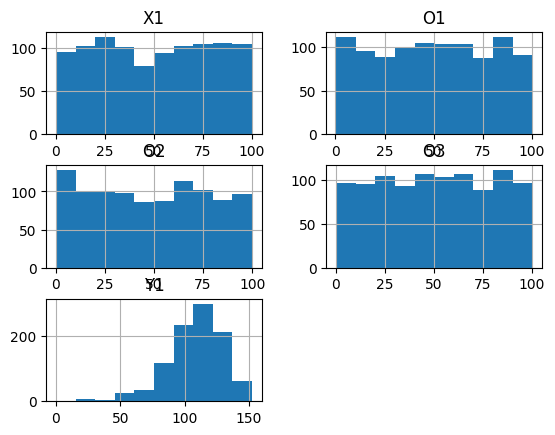

In [12]:
# hist all data
data_process_a.hist()

<Axes: >

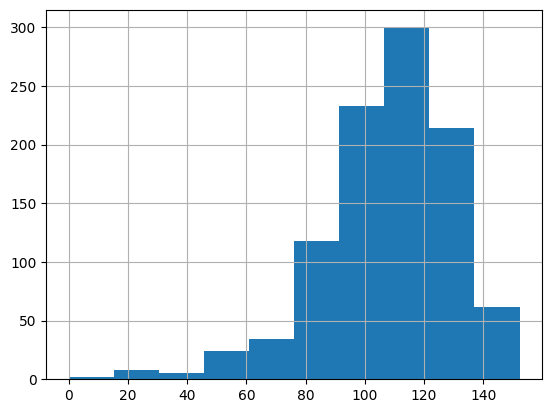

In [13]:
# histogram target
data_process_a['Y1'].hist()

#### 2.2 Process B - target Y2
Process B that see Z1, X2, O5, O6 and generate the target y2. That target is also shared with the output of the process C

In [14]:
list_features_process_b_y2 = [
    "Z1",
    "X2",
    "O5",
    "O6"
]

list_target_process_b_y2 = ["Y2"]

In [15]:
##### FEATURES

# generate data features process_b_y2
np.random.seed(62)

values_features_process_b_y2_secondary = np.array(data_process_a["Y1"]) + 200 # the input in the tank is the same if the volume is constant. 
# also in this example there are one extra flow
values_features_process_b_y2_secondary = np.expand_dims(values_features_process_b_y2_secondary, axis = 1)
values_features_process_b_y2_primary_observed = 10 * np.random.rand(len_data, len(list_features_process_b_y2)-1)

values_features_process_b_y2 = np.concatenate((values_features_process_b_y2_secondary, values_features_process_b_y2_primary_observed), axis = 1) 

In [16]:
#### TARGET y = f(x)

# define contribution of each feature into target value
# formula_target_process_b_y2 = (np.exp(-1/values_features_process_b_y2) + np.log(values_features_process_b_y2)).sum(axis = 1) # all features
contribution_target_process_b_y2_feature_0 = 1/3 * values_features_process_b_y2[:, 0]
contribution_target_process_b_y2_feature_1 = 15 * (np.exp(-1/values_features_process_b_y2[:, 1]))
contribution_target_process_b_y2_feature_2 = 2 * (np.exp(np.log(values_features_process_b_y2[:, 2])))
contribution_target_process_b_y2_feature_3 = -1/10 * (values_features_process_b_y2[:, 3])

# generate target -> sum individual contributions
formula_target_process_b_y2 = contribution_target_process_b_y2_feature_0 + contribution_target_process_b_y2_feature_1 + \
                            contribution_target_process_b_y2_feature_2 + contribution_target_process_b_y2_feature_3

# generate noise to add to the formula of the target generated
np.random.seed(12)
noise_target_process_b_y2 = 10 * np.random.rand(len_data, len(list_target_process_b_y2))

In [17]:
# GENERATE DATA_TARGET PROCESS B y2

# generate data target process_b_y2
values_target_process_b_y2  = formula_target_process_b_y2.reshape(formula_target_process_b_y2.shape[0], 1) + noise_target_process_b_y2
data_process_b_y2 = pd.DataFrame(values_features_process_b_y2, columns = list_features_process_b_y2)
data_process_b_y2[list_target_process_b_y2] = values_target_process_b_y2

data_process_b_y2

,Z1,X2,O5,O6,Y2
0,299.845222,0.337547,4.891075,8.460851,111.201405
1,291.956321,4.114020,6.314154,2.909432,128.819869
2,312.318699,5.428003,2.281814,2.402763,123.538904
3,342.317317,9.534575,6.458104,0.178572,145.847987
4,309.671948,9.961258,7.351945,7.219425,130.918964
...,...,...,...,...,...
995,335.164129,7.676773,8.853379,5.622381,148.683450
996,332.995228,7.624778,8.860129,6.958882,141.283171
997,329.397887,2.902402,6.884758,1.397521,142.739911
998,324.431951,0.359562,8.983187,2.696323,134.396831


In [18]:
# ## corr data
data_process_b_y2.corr()['Y2']

Z1    0.717116
X2    0.316397
O5    0.561734
O6   -0.034461
Y2    1.000000
Name: Y2, dtype: float64

array([[<Axes: title={'center': 'Z1'}>, <Axes: title={'center': 'X2'}>],
       [<Axes: title={'center': 'O5'}>, <Axes: title={'center': 'O6'}>],
       [<Axes: title={'center': 'Y2'}>, <Axes: >]], dtype=object)

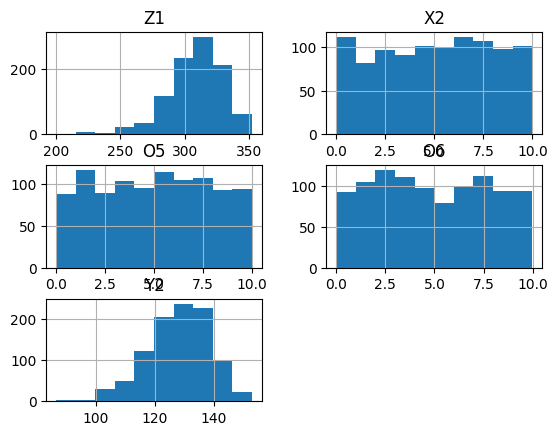

In [19]:
# hist all features
data_process_b_y2.hist()

<Axes: >

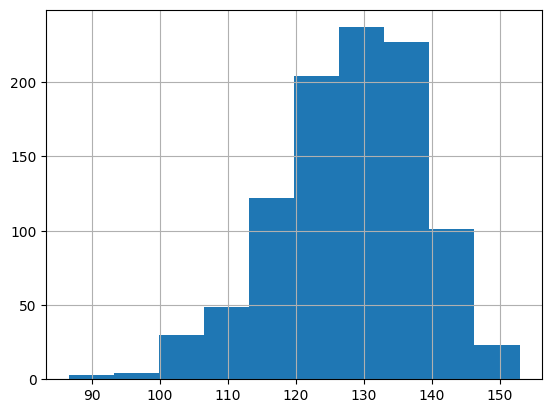

In [20]:
# histogram target
data_process_b_y2['Y2'].hist()

In [21]:
### revisar correlaciones entre Y1 (entrada tanque) y z1 (salida tanque)
data_process_a['Y1']

0       99.845222
1       91.956321
2      112.318699
3      142.317317
4      109.671948
          ...    
995    135.164129
996    132.995228
997    129.397887
998    124.431951
999    115.505074
Name: Y1, Length: 1000, dtype: float64

In [22]:
data_process_b_y2['Z1']

0      299.845222
1      291.956321
2      312.318699
3      342.317317
4      309.671948
          ...    
995    335.164129
996    332.995228
997    329.397887
998    324.431951
999    315.505074
Name: Z1, Length: 1000, dtype: float64

#### 2.3 Process C
This process has its own formula as ml models. 

- To use this formula in gurobi it is necesary define the formula directly as constraint. So, the formula used here is the original formula that will be used as "model"

- Also, according the diagram of the process that we try to modelate, the target of this process needs to be the same target of the process B

In [23]:
list_features_process_c = [
    "X3",
    "O7",
]

list_target_process_c = ["Y2"]

In [24]:
#### TARGET

# the target of the process needs to be the same of the target of process B
values_target_process_c = np.array(data_process_b_y2["Y2"])
values_target_process_c = np.expand_dims(values_target_process_c, axis = 1)

In [25]:
##### FEATURES - fixed one feature and the another feature is calcualated according the alpha defined

# generate data feature 1 process_c 
np.random.seed(62)
values_features_process_c_feature1 = 10 * np.random.rand(len_data, len(list_features_process_c)-1)

# the features needs a parameter alpha in the formula that maps this values into the target
alpha_feature_1 = 1/5
alpha_feature_2 = 15
values_features_process_c_feature2 = (values_target_process_c - alpha_feature_1 * values_features_process_c_feature1) / alpha_feature_2
#values_features_process_c_feature2[values_features_process_c_feature2 < 0] = 0

values_features_process_c = np.concatenate((values_features_process_c_feature1, values_features_process_c_feature2), axis = 1)

In [26]:
# generate dataframe process_c
data_process_c = pd.DataFrame(values_features_process_c, columns = list_features_process_c)
data_process_c[list_target_process_c] = values_target_process_c
data_process_c

,X3,O7,Y2
0,0.337547,7.408926,111.201405
1,4.891075,8.522777,128.819869
2,8.460851,8.123116,123.538904
3,4.114020,9.668346,145.847987
4,6.314154,8.643742,130.918964
...,...,...,...
995,4.983054,9.845789,148.683450
996,3.887887,9.367040,141.283171
997,5.537505,9.442161,142.739911
998,4.707576,8.897021,134.396831


In [27]:
data_process_c.min()

X3     0.000558
O7     5.709173
Y2    86.579782
dtype: float64

array([[<Axes: title={'center': 'X3'}>, <Axes: title={'center': 'O7'}>],
       [<Axes: title={'center': 'Y2'}>, <Axes: >]], dtype=object)

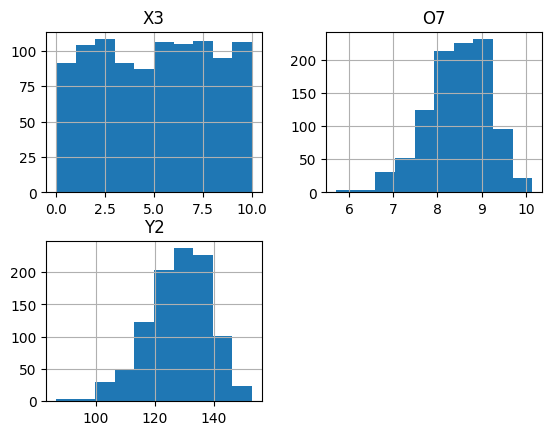

In [28]:
data_process_c.hist()

In [29]:
data_process_c.corr()['Y2']

X3   -0.045602
O7    0.998532
Y2    1.000000
Name: Y2, dtype: float64

<Axes: >

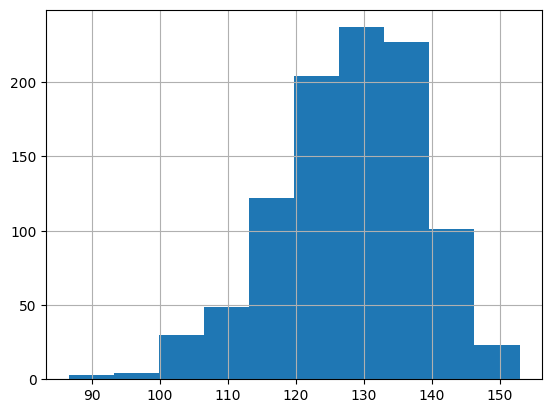

In [30]:
# hist target
data_process_c['Y2'].hist()

#### 2.4 Process B - target Y3
Process B that see Z1, X2, and generate the target y3. 
See that the process B has 2 targets.
See that to generate target y3 it is necesary only the features Z1 and X2 and it is not necesary the features O5 and O6

In [31]:
list_features_process_b_y3 = [
    "Z1",
    "X2"
]

list_target_process_b_y3 = ["Y3"]

In [32]:
##### FEATURES - the features are already generated
data_process_b_y3 = data_process_b_y2[list_features_process_b_y3]
data_process_b_y3.head()

,Z1,X2
0,299.845222,0.337547
1,291.956321,4.114020
2,312.318699,5.428003
3,342.317317,9.534575
4,309.671948,9.961258


In [33]:
#### TARGET y = f(x)

# define contribution of each feature into target value
contribution_target_process_b_y3_feature_1 = 2 * (np.exp(np.log( data_process_b_y3.iloc[:, 0] )))
contribution_target_process_b_y3_feature_2 = -1/10 * data_process_b_y3.iloc[:, 1]

# generate target -> sum individual contributions
formula_target_process_b_y3 = contribution_target_process_b_y3_feature_1 + contribution_target_process_b_y3_feature_2

In [34]:
# GENERATE DATA_TARGET PROCESS B y3
values_target_process_b_y3  = np.array(formula_target_process_b_y3)
data_process_b_y3.loc[:, 'Y3'] = values_target_process_b_y3

data_process_b_y3

/var/folders/fx/0kx46vn52sg544t8x3s4hdl00000gn/T/ipykernel_60220/2602898210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_process_b_y3.loc[:, 'Y3'] = values_target_process_b_y3


,Z1,X2,Y3
0,299.845222,0.337547,599.656689
1,291.956321,4.114020,583.501239
2,312.318699,5.428003,624.094597
3,342.317317,9.534575,683.681177
4,309.671948,9.961258,618.347769
...,...,...,...
995,335.164129,7.676773,669.560580
996,332.995228,7.624778,665.227978
997,329.397887,2.902402,658.505533
998,324.431951,0.359562,648.827945


<Axes: >

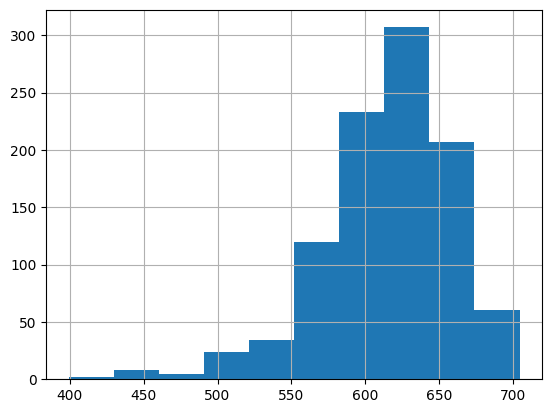

In [35]:
# histogram target
data_process_b_y3['Y3'].hist()

### 3. Evaluate capacity of ml model and split data
Evaluate the capacity of a Machine Learning model to predict this data. For this example it will use only a simple linear regression

#### 3.1 Process A

In [36]:
# list features-target
features_train_process_a = data_process_a.columns.tolist()[0:-1]
target_process_a = [data_process_a.columns.tolist()[-1]]

# generate data
X_process_a = data_process_a[features_train_process_a]
y_process_a = data_process_a[target_process_a]

# split train test
X_train_process_a, X_test_process_a, y_train_process_a, y_test_process_a = train_test_split(X_process_a,
                                                                                            y_process_a,
                                                                                            test_size = 0.2,
                                                                                            random_state = 42
                                                                                           )

# train model
lr_process_a = LinearRegression()
lr_process_a.fit(X_train_process_a, y_train_process_a)

# evaluate
lr_process_a.score(X_test_process_a, y_test_process_a)

0.818572112755708

In [37]:
X_process_a

,X1,O1,O2,O3
0,37.467481,95.270644,73.200558,60.013231
1,15.615333,15.798666,5.809525,86.764997
2,60.124970,71.006471,2.059613,97.138367
3,83.257733,21.433125,18.183660,18.487833
4,30.437694,52.674857,43.195665,29.270296
...,...,...,...,...
995,83.249823,80.764094,22.433019,22.755289
996,81.744001,93.239056,9.537256,45.153246
997,33.758897,87.268059,8.353655,21.259976
998,75.260303,5.328598,49.254702,44.358086


#### 3.2 Process B y2

In [38]:
# list features-target
features_train_process_b_y2 = data_process_b_y2.columns.tolist()[0:-1]
target_process_b_y2 = [data_process_b_y2.columns.tolist()[-1]]

# generate data
X_process_b_y2 = data_process_b_y2[features_train_process_b_y2]
y_process_b_y2 = data_process_b_y2[target_process_b_y2]

X_train_process_b_y2, X_test_process_b_y2, y_train_process_b_y2, y_test_process_b_y2 = train_test_split(X_process_b_y2,
                                                                                                        y_process_b_y2,
                                                                                                        test_size = 0.2,
                                                                                                        random_state = 42
                                                                                                       )

# train model
lr_process_b_y2 = LinearRegression()
lr_process_b_y2.fit(X_train_process_b_y2, y_train_process_b_y2)

# evaluate
lr_process_b_y2.score(X_test_process_b_y2, y_test_process_b_y2)

0.8936387673859321

#### 3.3 Process B y3

In [39]:
# list features-target
features_train_process_b_y3 = data_process_b_y3.columns.tolist()[0:-1]
target_process_b_y3 = [data_process_b_y3.columns.tolist()[-1]]

# generate data
X_process_b_y3 = data_process_b_y3[features_train_process_b_y3]
y_process_b_y3 = data_process_b_y3[target_process_b_y3]

X_train_process_b_y3, X_test_process_b_y3, y_train_process_b_y3, y_test_process_b_y3 = train_test_split(X_process_b_y3,
                                                                                                        y_process_b_y3,
                                                                                                        test_size = 0.2,
                                                                                                        random_state = 42
                                                                                                       )

# train model
lr_process_b_y3 = LinearRegression()
lr_process_b_y3.fit(X_train_process_b_y3, y_train_process_b_y3)

# evaluate
lr_process_b_y3.score(X_test_process_b_y3, y_test_process_b_y3)

1.0

#### 3.4 Process C

In [40]:
# list features-target
features_train_process_c = data_process_c.columns.tolist()[0:-1]
target_process_c = [data_process_c.columns.tolist()[-1]]

# generate data
X_process_c = data_process_c[features_train_process_c]
y_process_c = data_process_c[target_process_c]

# split train test
X_train_process_c, X_test_process_c, y_train_process_c, y_test_process_c = train_test_split(X_process_c,
                                                                                            y_process_c,
                                                                                            test_size = 0.2,
                                                                                            random_state = 42
                                                                                           )

# train model
lr_process_c = LinearRegression()
lr_process_c.fit(X_train_process_c, y_train_process_c)

# evaluate
lr_process_c.score(X_test_process_c, y_test_process_c)

1.0

### 4. Save Data

#### 4.1 Process A

In [41]:
### save data TRAIN - TEST
name_model = 'process_a'


# ---
# save X_train
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_a, output)
    output.close()

# save y_train
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_a, output)
    output.close()


# ---
# save X_test
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_a, output)
    output.close()

# save y_test
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_a, output)
    output.close()

#### 4.2 Process B y2

In [42]:
### save data TRAIN - TEST
name_model = 'process_b_y2'


# ---
# save X_train y2
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_b_y2, output)
    output.close()

# save y_train y2
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_b_y2, output)
    output.close()


# ---
# save X_test y2
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_b_y2, output)
    output.close()

# save y_test y2
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_b_y2, output)
    output.close()

#### 4.3 Process B y3

In [43]:
### save data TRAIN - TEST
name_model = 'process_b_y3'


# ---
# save X_train y2
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_b_y3, output)
    output.close()

# save y_train y2
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_b_y3, output)
    output.close()


# ---
# save X_test y2
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_b_y3, output)
    output.close()

# save y_test y2
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_b_y3, output)
    output.close()

#### 4.4 Process C

In [44]:
### save data TRAIN - TEST
name_model = 'process_c'


# ---
# save X_train
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_c, output)
    output.close()

# save y_train
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_c, output)
    output.close()


# ---
# save X_test
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_c, output)
    output.close()

# save y_test
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_c, output)
    output.close()